# Deep-Flow: Worst-Case Error Analysis
Identifying and visualizing the scenarios where the model's Log-Likelihood/Loss is worst.

In [1]:
import matplotlib
if not hasattr(matplotlib.RcParams, '_get'):
    matplotlib.RcParams._get = lambda self, key: self.get(key)

import matplotlib.pyplot as plt
import os
import sys
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from omegaconf import OmegaConf

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.deep_flow import DeepFlow
from src.dataset.waymo_dataset import WaymoDataset
from src.engine.losses import CFMLoss
from src.utils.visualization import plot_scenario

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
# ## 1. Load Model & Data

# %%
cfg = OmegaConf.load("../configs/main_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepFlow(cfg).to(device)
checkpoint_path = "../checkpoints/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model'])
model.eval()

# Ensure we use in_memory for speed during the big loop
val_set = WaymoDataset(cfg, split='validation', in_memory=True)
criterion = CFMLoss(cfg=cfg, sigma_min=1e-4).to(device)

/home/anton/Deep-Flow/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


🚀 Parallel Eager Load (20 workers)...


100%|██████████| 8856/8856 [00:12<00:00, 727.14it/s]


✅ validation split loaded. Count: 8856


## 2. Calculate Loss for Entire Validation Set
We compute a stable average loss (5 time samples per scenario) to rank them.

In [5]:
results = []

print("Running batch inference for error ranking...")
for i in tqdm(range(len(val_set))):
    batch = val_set[i]
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}
    
    with torch.no_grad():
        # Average over 5 samples for a stable ranking
        scenario_losses = []
        for _ in range(5):
            # The CFMLoss.forward calls model(batch, xt, t) 
            # Our updated model internaly handles the context/goal_emb split
            total_loss, flow_loss, coord_loss = criterion(model, batch_torch)
            scenario_losses.append(total_loss.item())
        
        avg_l = np.mean(scenario_losses)
        
    results.append({
        'index': i,
        'scenario_id': batch['scenario_id'],
        'loss': avg_l
    })

df_errors = pd.DataFrame(results).sort_values(by='loss', ascending=False)
print("\nTop 5 Highest Error Scenarios:")
print(df_errors.head(5))

Running batch inference for error ranking...


100%|██████████| 8856/8856 [02:39<00:00, 55.48it/s]


Top 5 Highest Error Scenarios:
      index       scenario_id       loss
6223   6223  87ab9209bd66ea66  12.397196
863     863  bc2831e457e19a99  12.148171
299     299  f4f56bcab6c2ca65   9.947024
4932   4932  1351d65dc03048c7   9.570908
2331   2331  20d181afd1d5865b   9.386026


## 3. Visualize the "Worst" Scenarios
We will look at the Top 5 to see why the model is struggling.

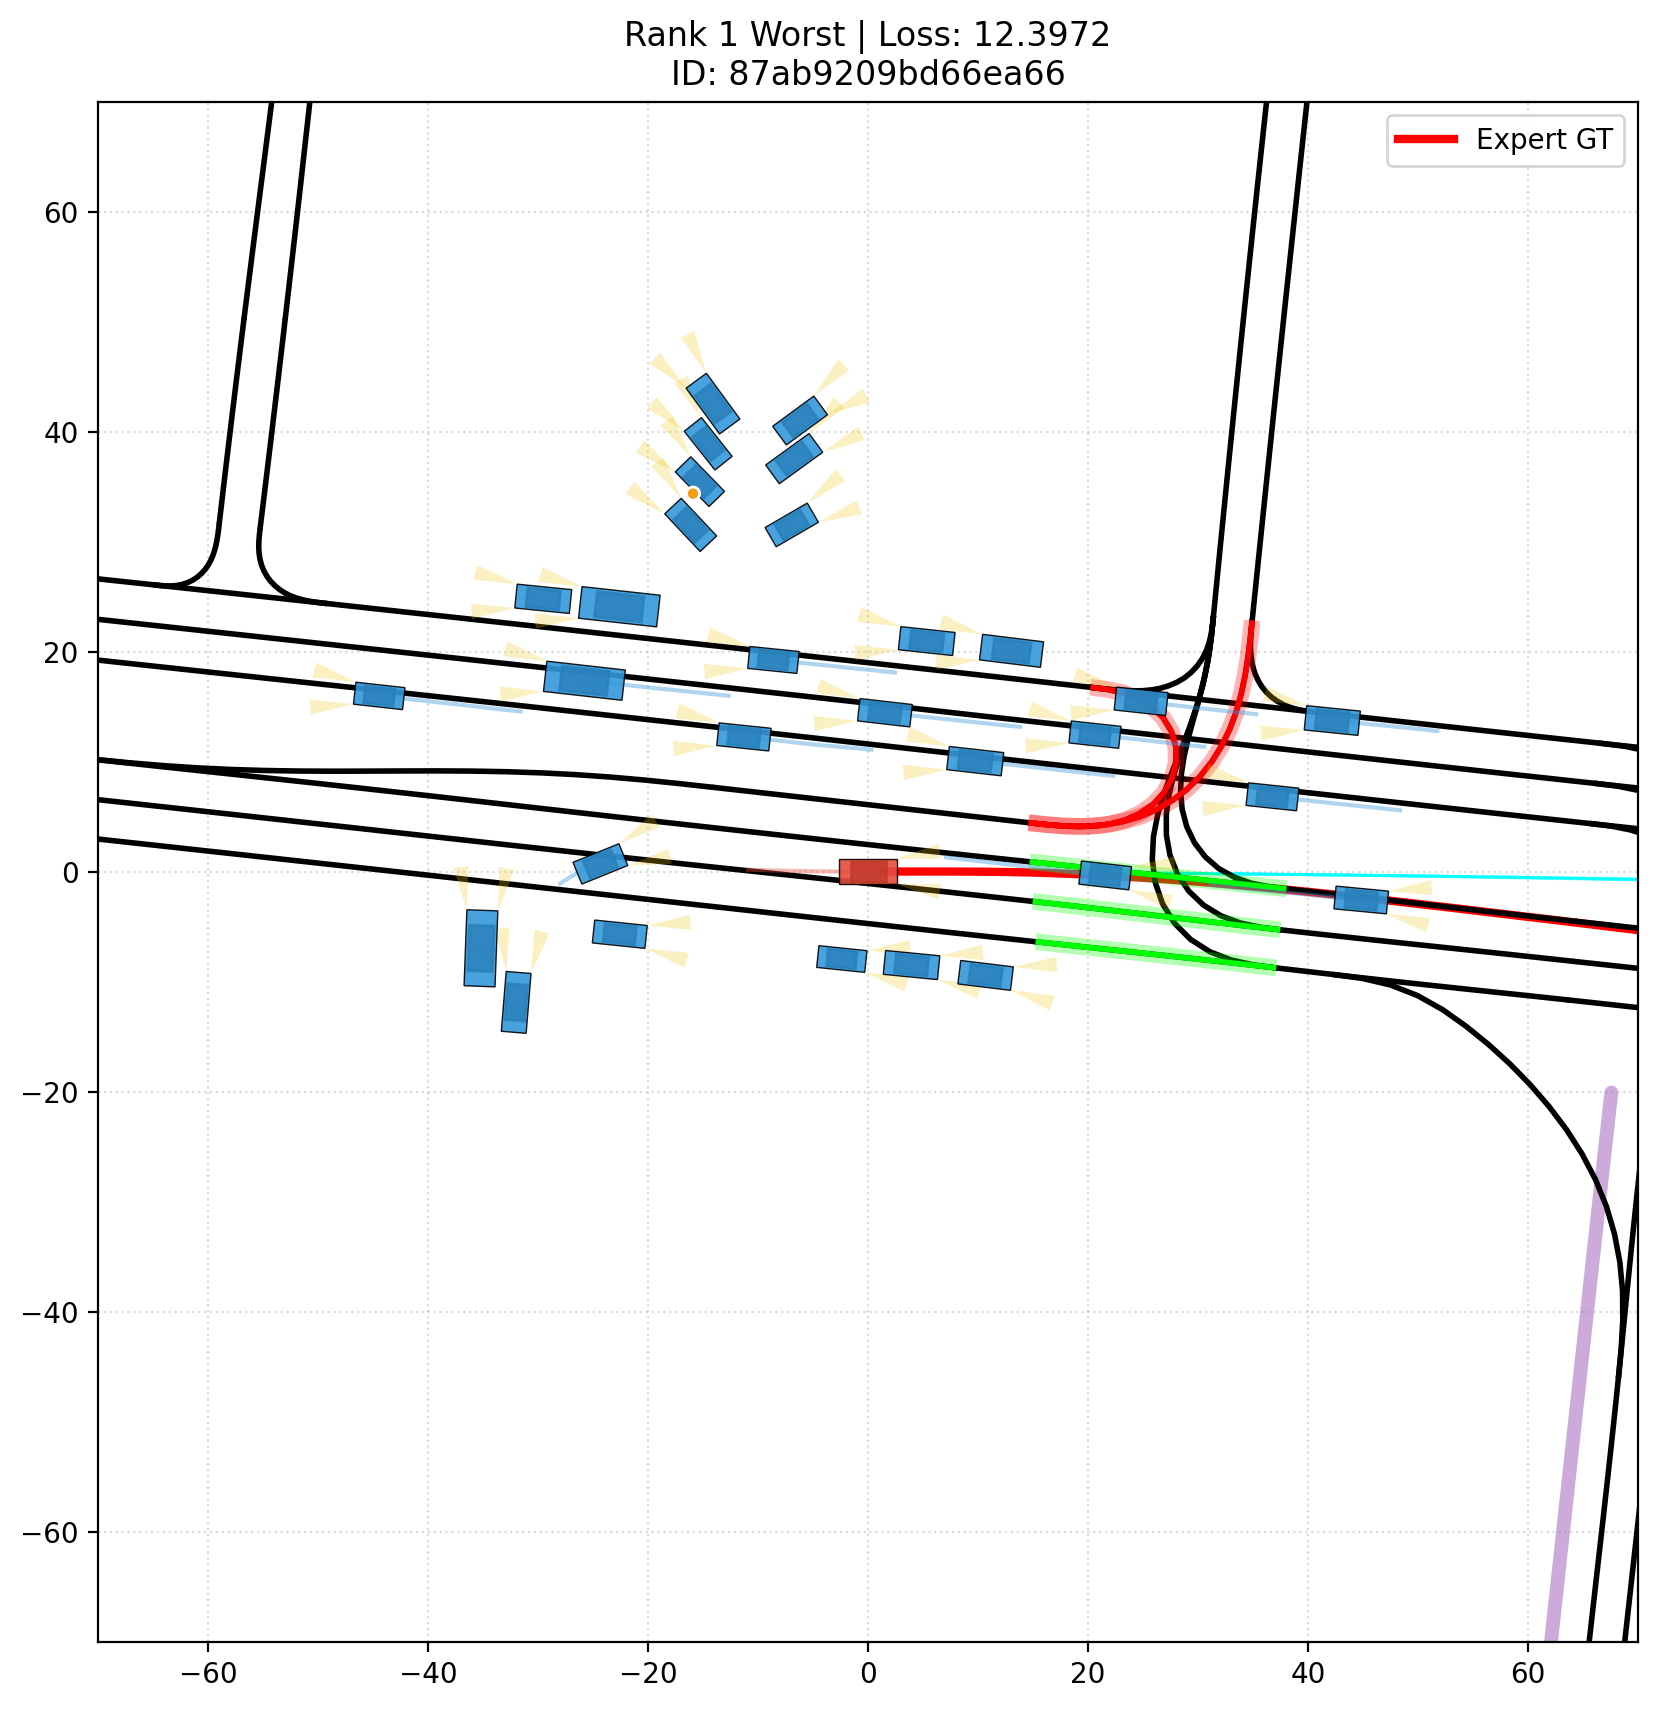

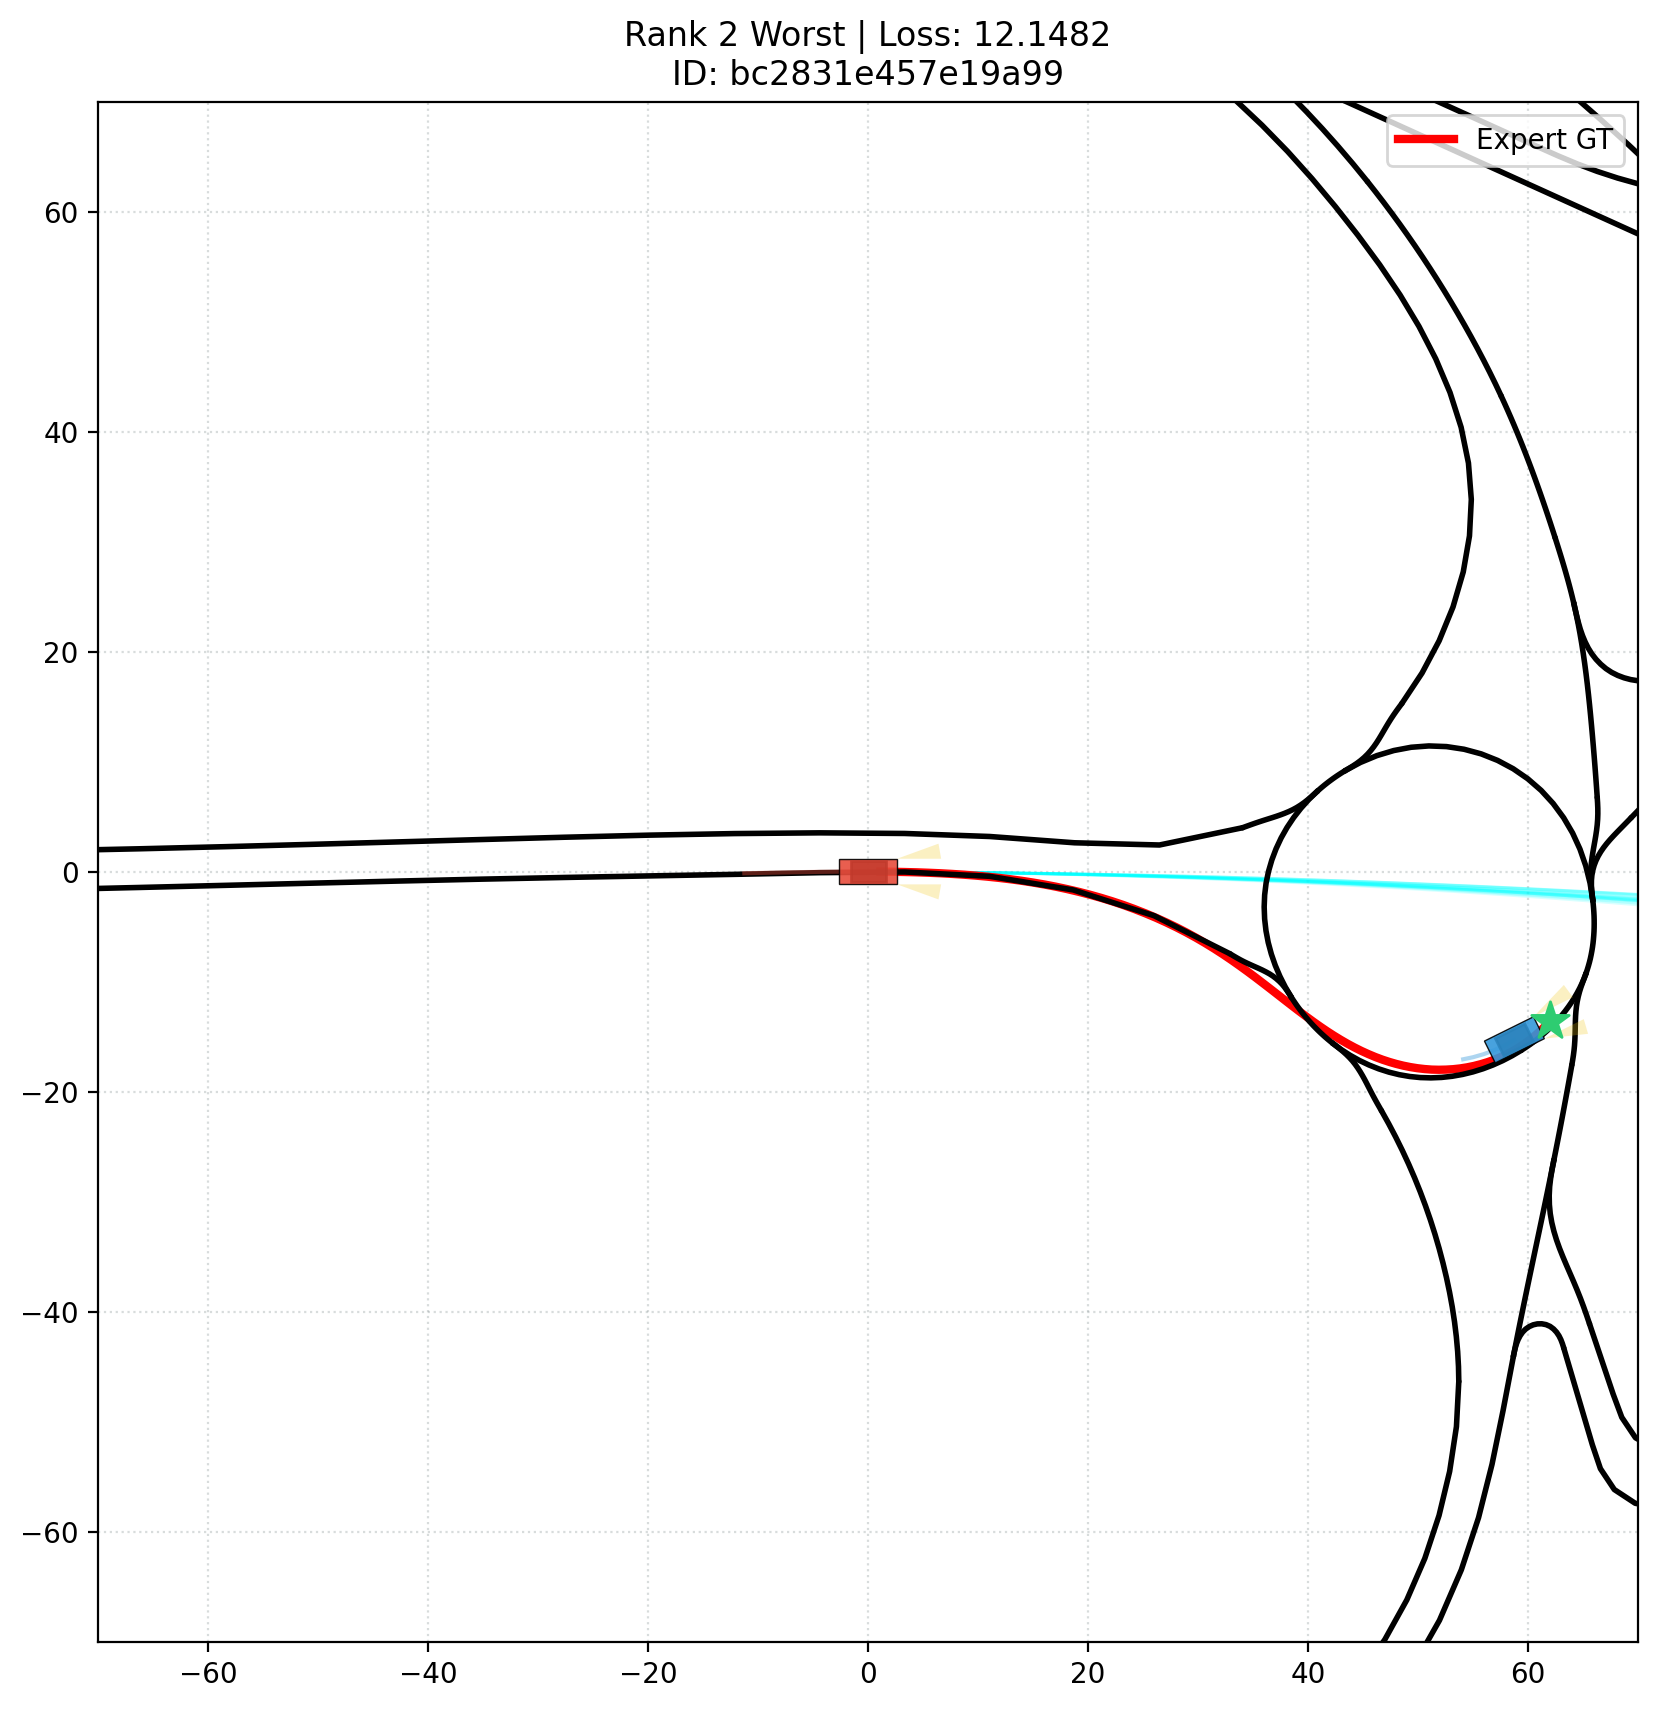

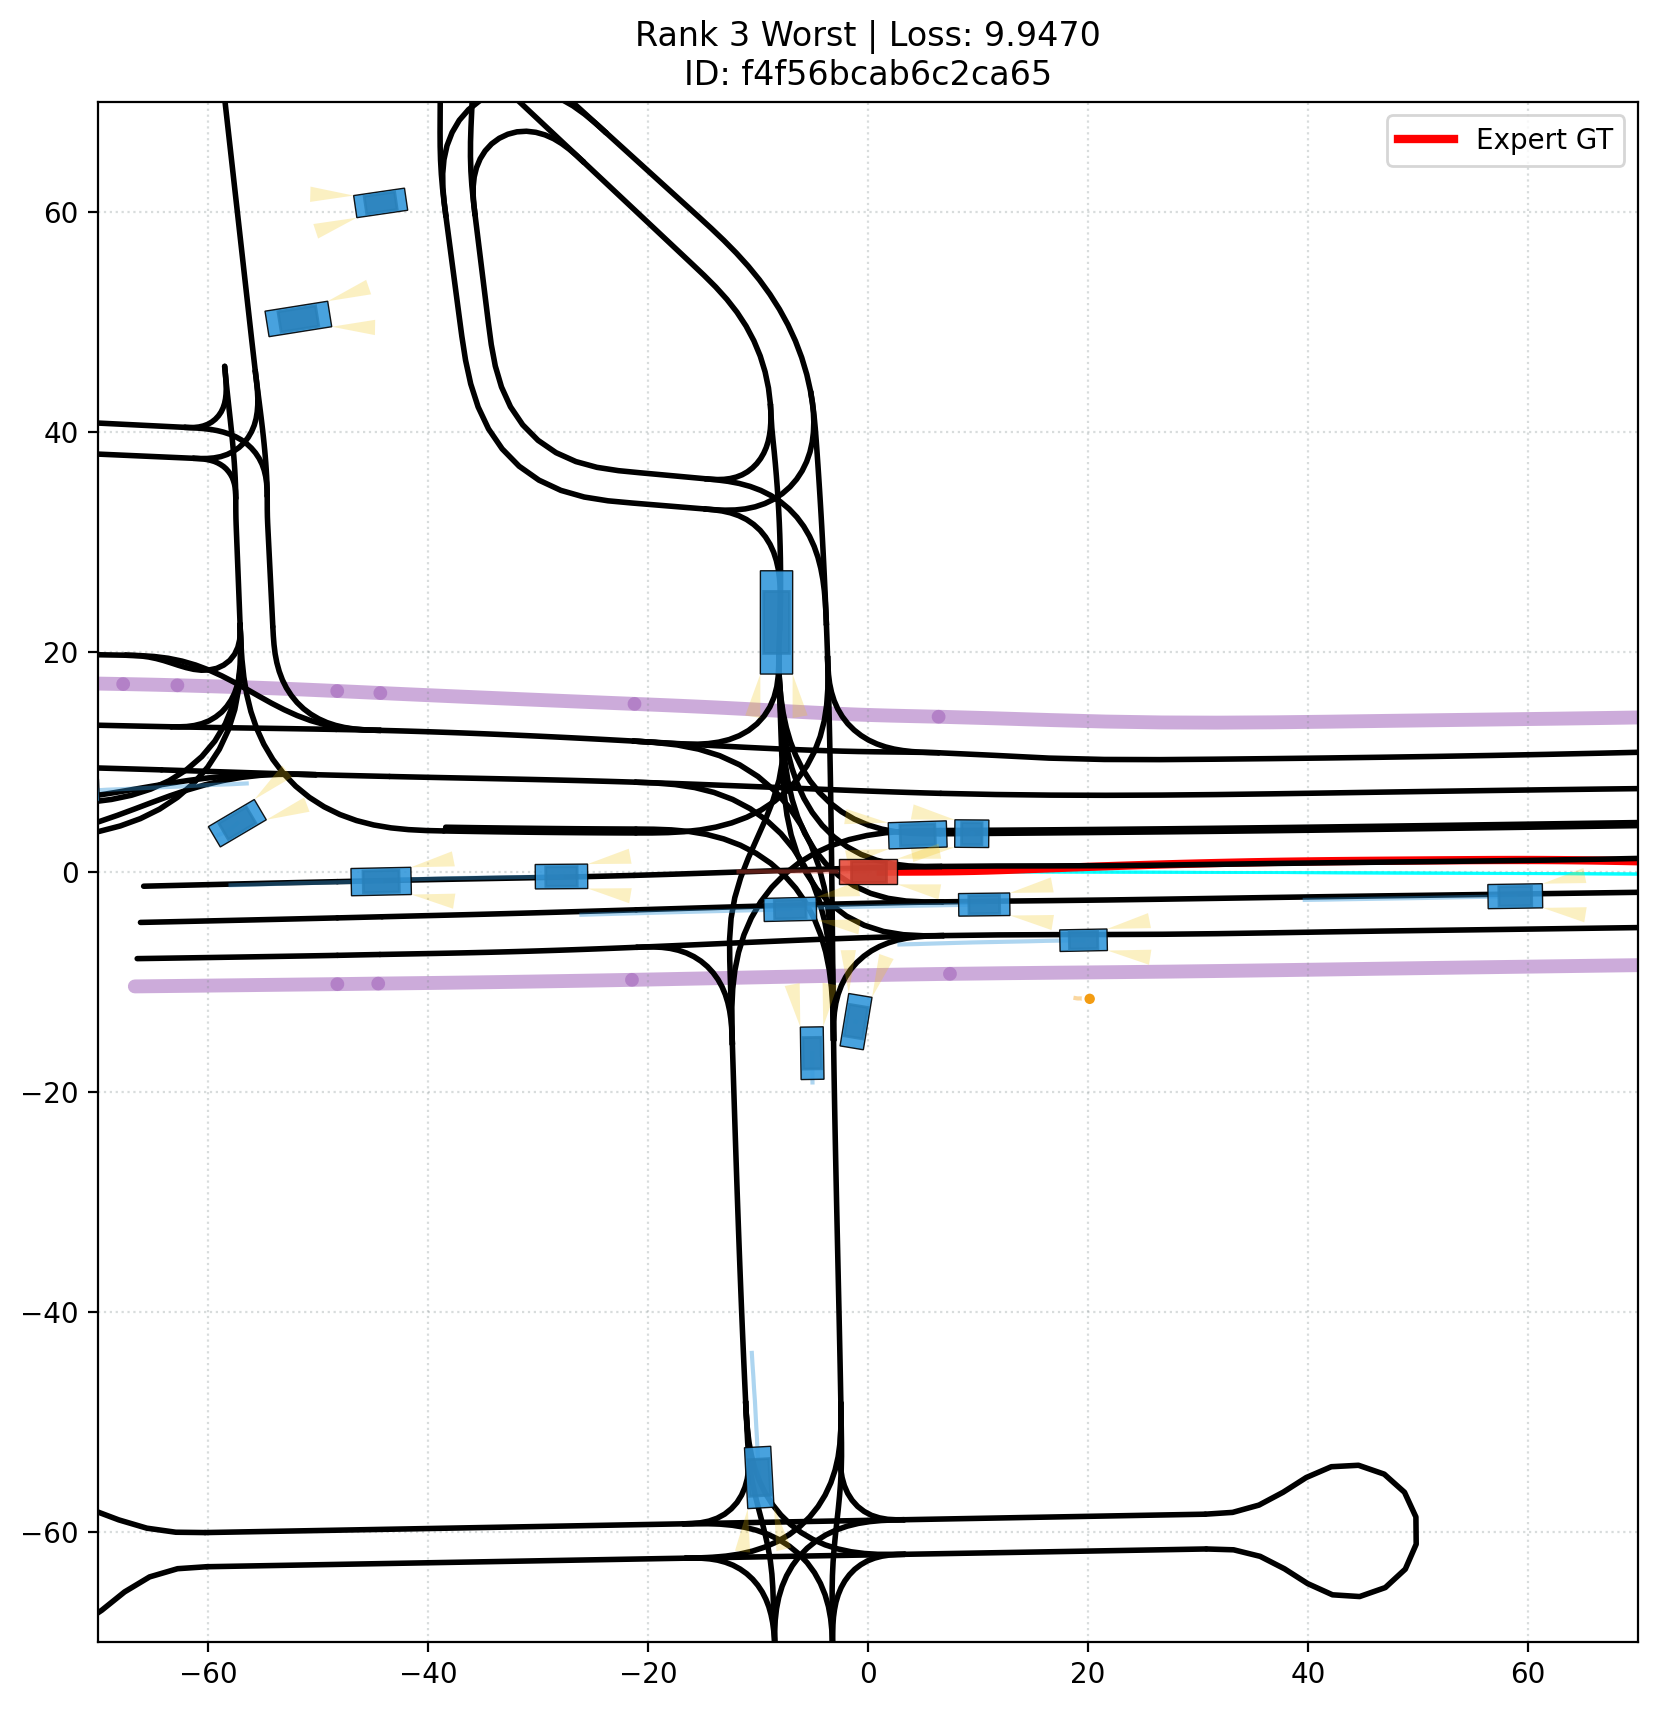

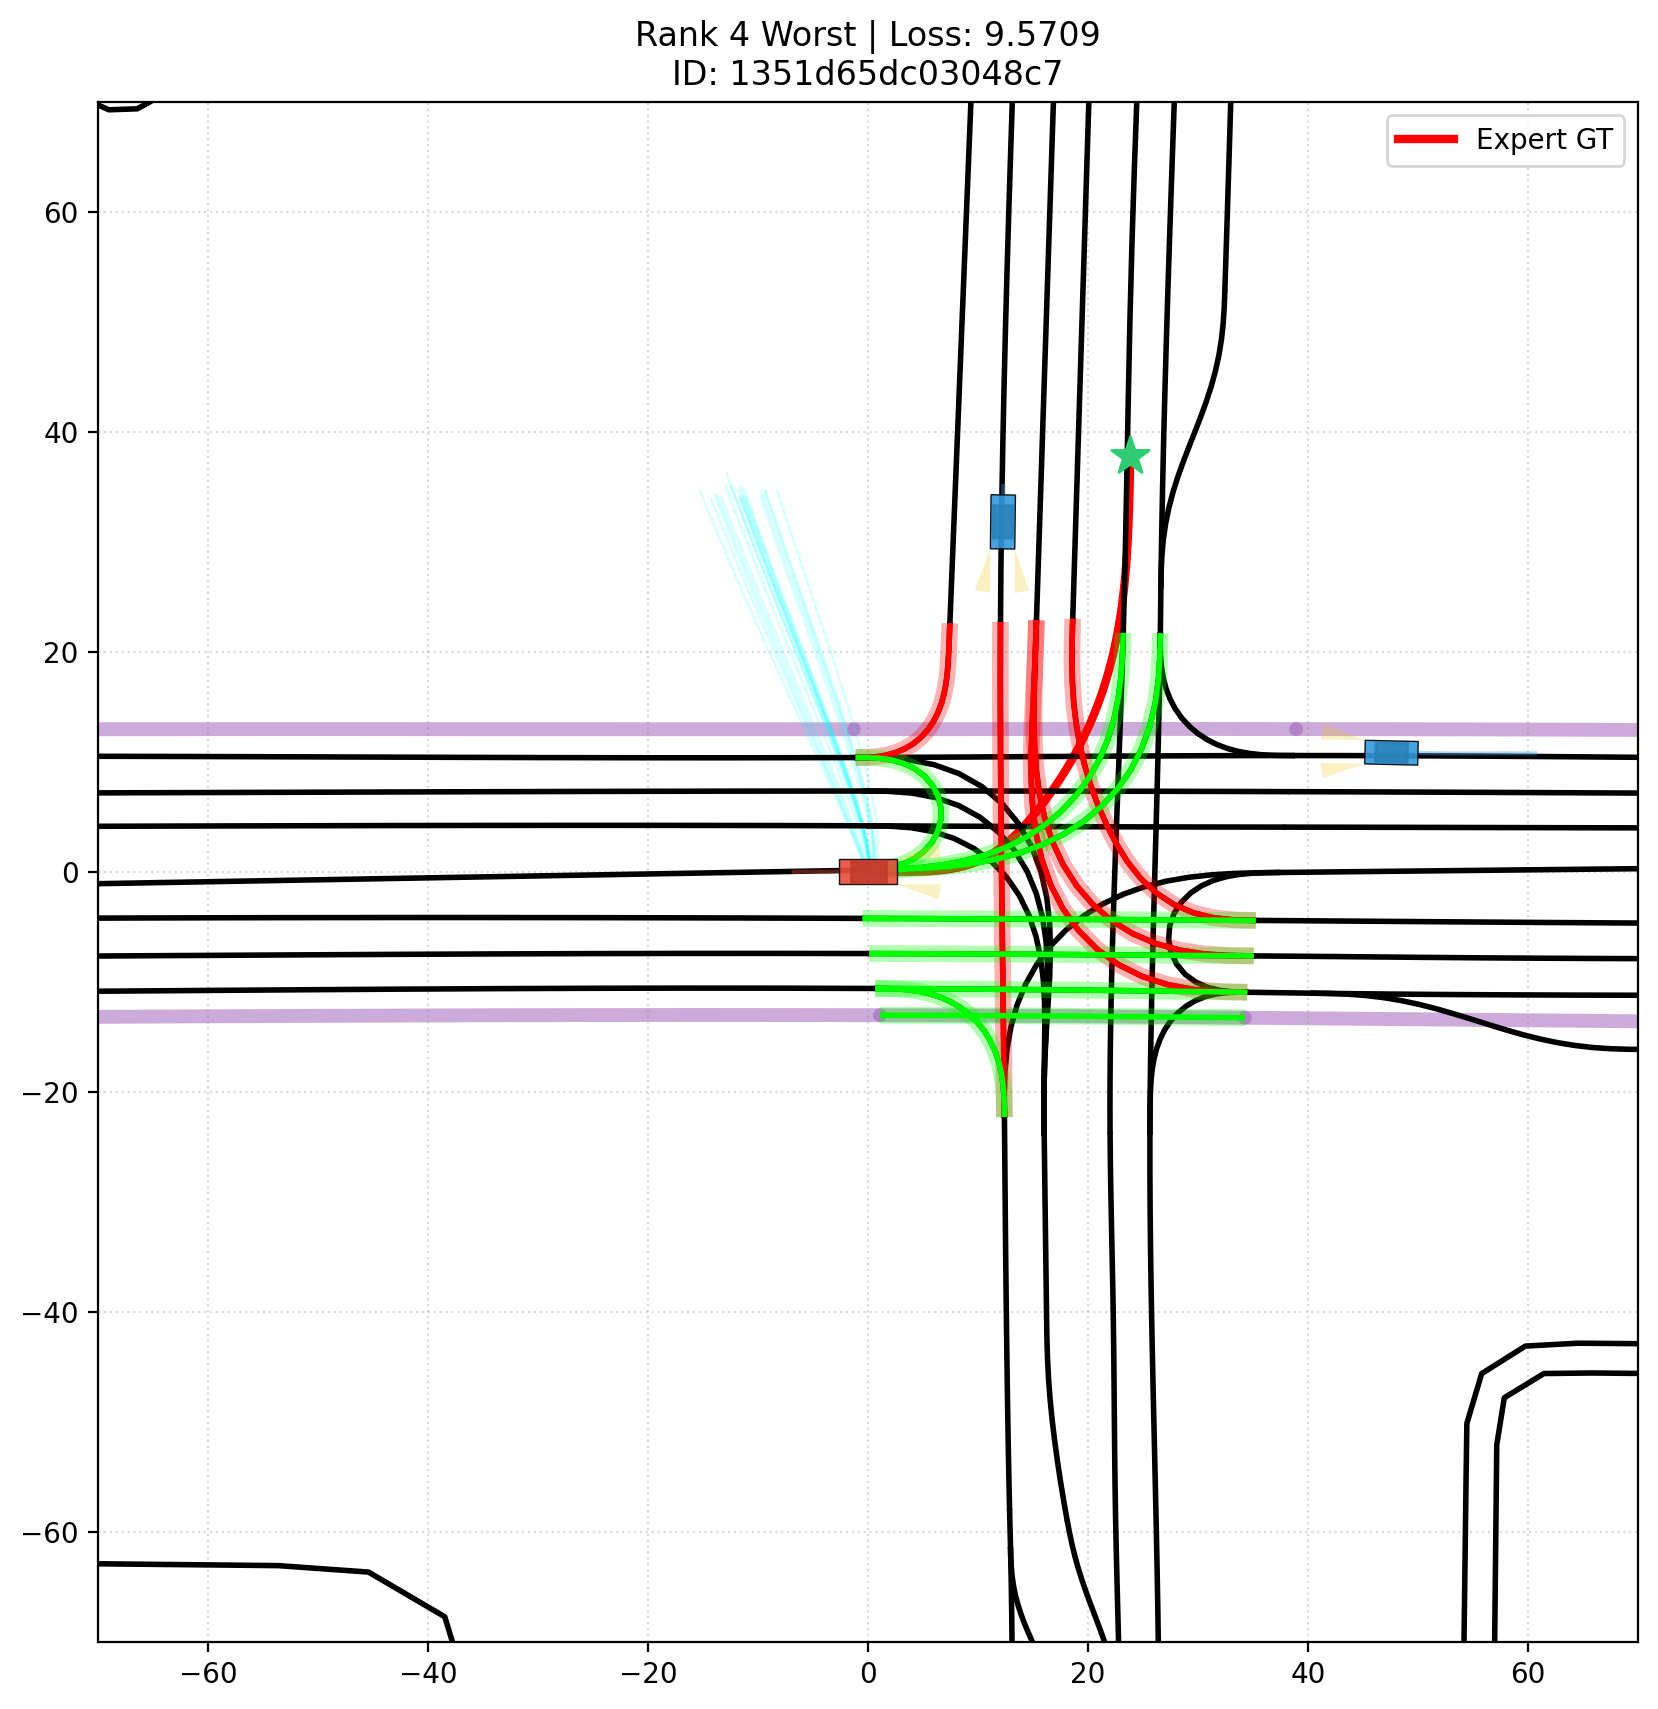

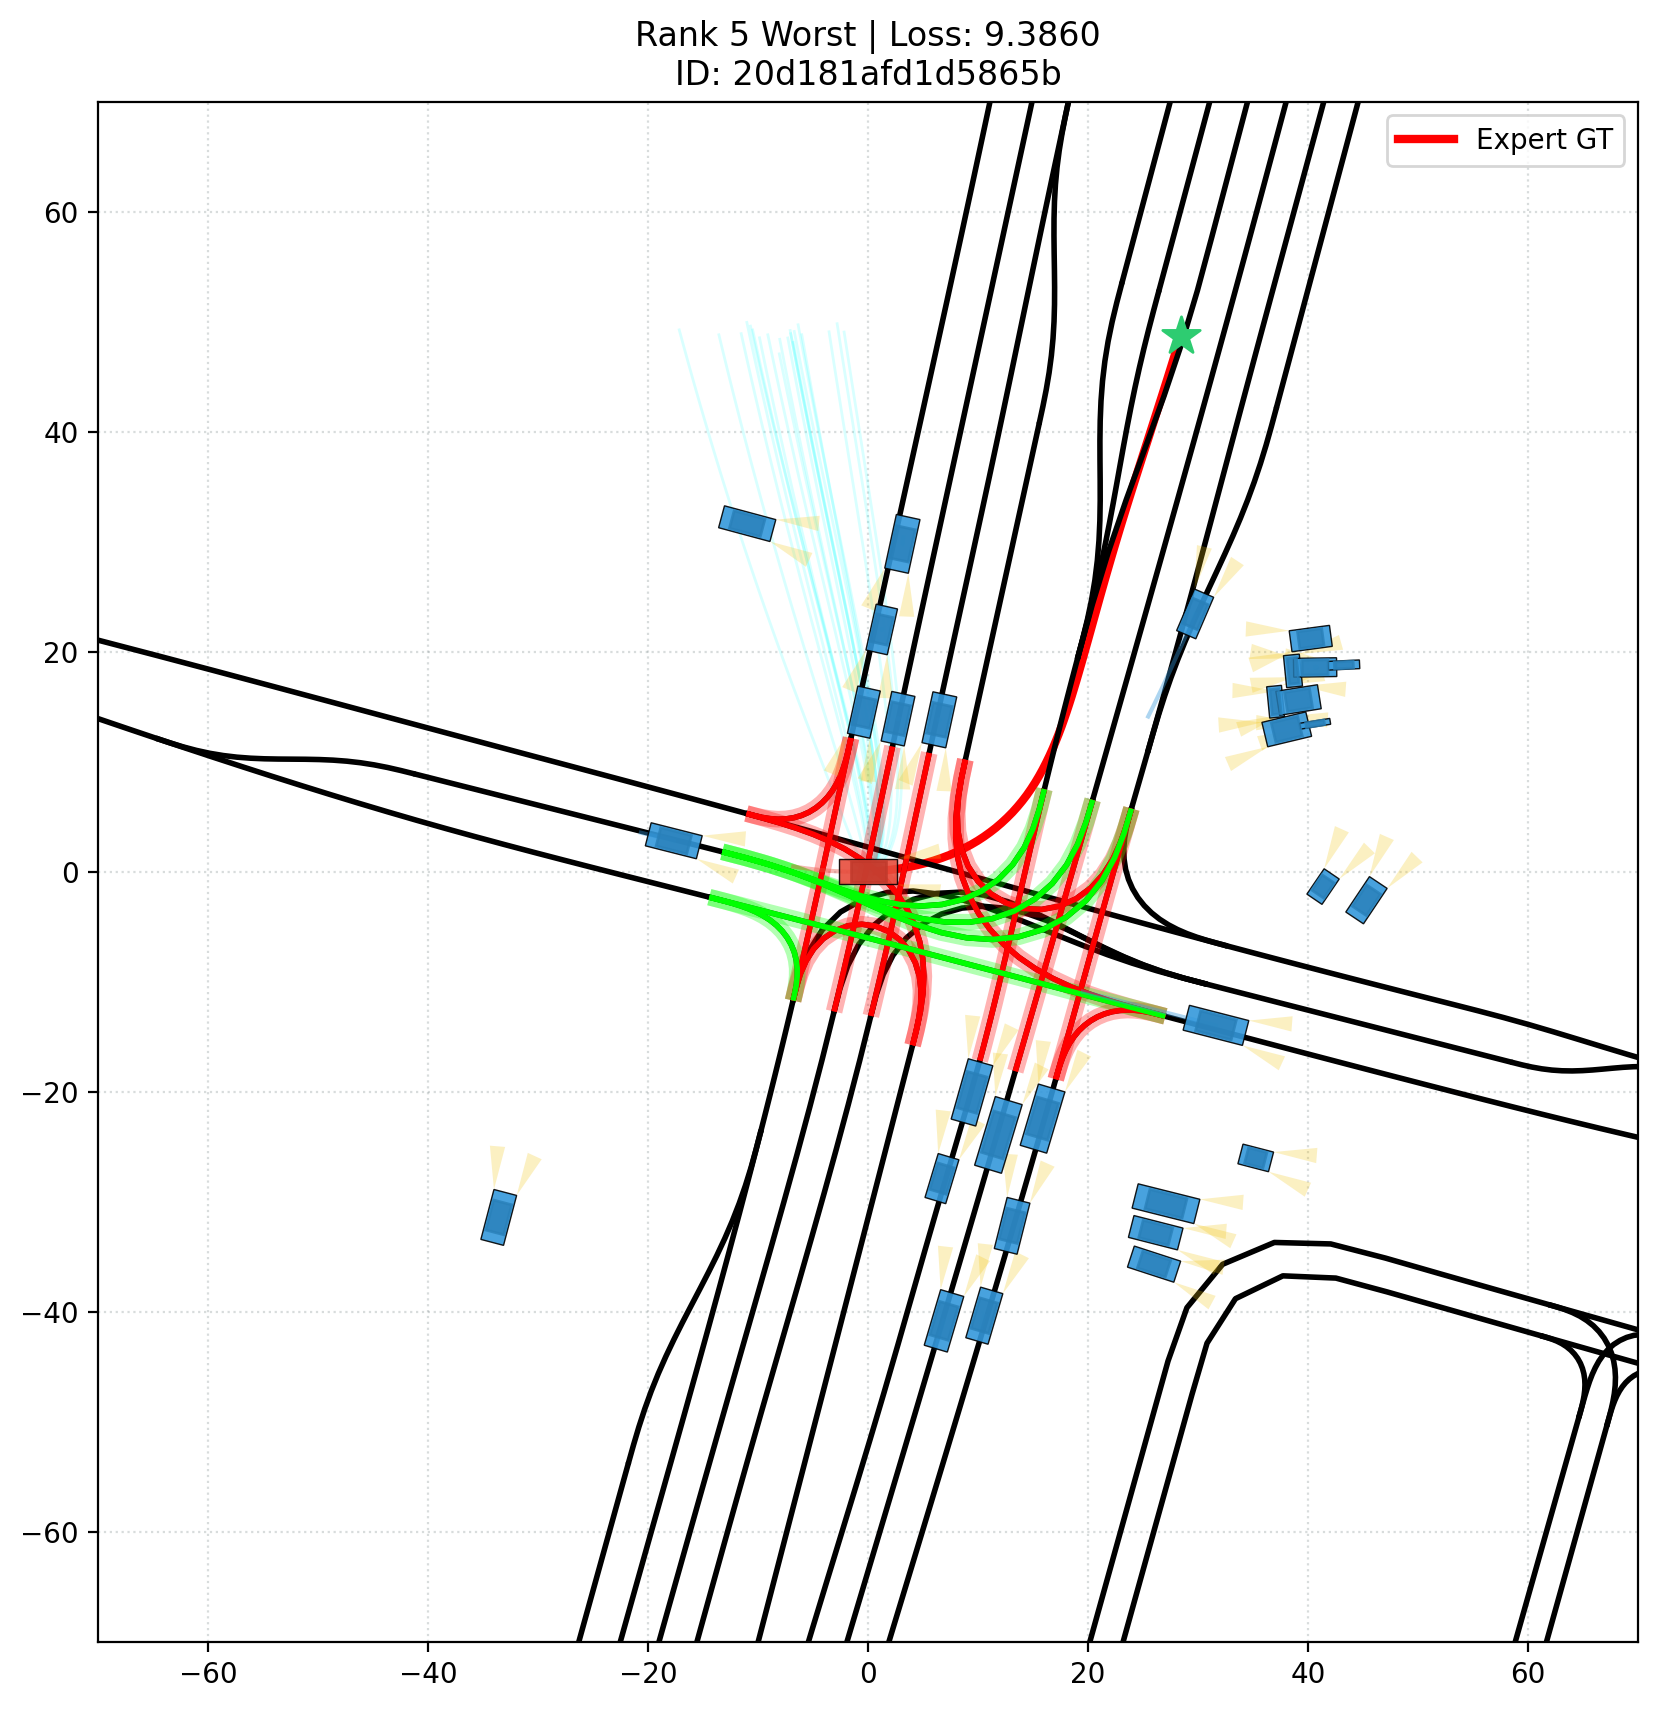

In [7]:
import json
# Helper function for un-normalization (Fixed Scaling 50.0)
def generate_and_reconstruct(model, batch_torch, pca_data, num_samples=20):
    comp = torch.tensor(pca_data['components'], device=device).float()
    p_mean = torch.tensor(pca_data['mean'], device=device).float()
    stds = torch.tensor(pca_data['stds'], device=device).float()
    
    context, goal_emb = model.encoder(
        batch_torch['agent_context'], batch_torch['agent_mask'], 
        batch_torch['map_context'], batch_torch['map_mask'], batch_torch['goal_pos']
    )
    
    # Integration (Euler 50 steps)
    curr = torch.randn(num_samples, 12, device=device)
    dt = 1.0 / 50
    for i in range(50):
        v = model.flow_head(curr, torch.ones(num_samples, device=device) * (i*dt), 
                            context.repeat(num_samples,1), goal_emb.repeat(num_samples,1))
        curr = curr + v * dt
    
    # Reconstruction Chain
    trajs = (torch.matmul(curr * stds, comp) + p_mean).view(num_samples, 80, 2) * 50.0
    return trajs.detach().cpu().numpy()

# Load PCA basis once
with open("/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json", "r") as f:
    pca_data = json.load(f)

# Visualize Top 5
for rank, (row_idx, row) in enumerate(df_errors.head(5).iterrows()):
    idx = int(row['index'])
    batch = val_set[idx]
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    
    # Find raw file for map/types
    found_path = next(p for p in val_set.file_list if batch['scenario_id'] in p)
    raw_data = np.load(found_path)
    
    hallucinations = generate_and_reconstruct(model, batch_torch, pca_data)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_scenario(raw_data, ax=ax, show_future=False)
    
    # Hallucinations
    for h in hallucinations: ax.plot(h[:, 0], h[:, 1], color='cyan', alpha=0.15, lw=1)
    # Expert
    gt = raw_data['agents'][0, 11:91, :2]
    ax.plot(gt[:, 0], gt[:, 1], color='red', lw=3, label='Expert GT')
    # Goal
    goal_m = batch['goal_pos'].numpy() * 50.0
    ax.scatter(goal_m[0], goal_m[1], color='#2ecc71', s=200, marker='*', zorder=10)
    
    ax.set_title(f"Rank {rank+1} Worst | Loss: {row['loss']:.4f}\nID: {row['scenario_id']}")
    plt.legend()
    plt.show()